In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file = os.path.join(dirname, filename)
        print(file)

# Any results you write to the current directory are saved as output.

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


In [2]:
ds = pd.read_csv(file)
print(ds.columns)
print(ds.info())
print(ds.isnull().sum())


Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
CustomerID                200 non-null int64
Gender                    200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [3]:
print(ds.describe())

       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


* 25% of the customers have their age between 18 and 29 years
* 50% of the customers have their age between 18 and 36 years
* 50% of the customers have an annual income less than 62K, maximum being 137K
* 50% of the customers have a spending score of 50

Gender is the only non-numerical feature - we will encode it using LabelEncoder()

In [4]:
print(ds["Gender"].unique())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ds["enc_gender"] = le.fit_transform(ds["Gender"])
'''Get gender integer label mapping'''
mapping = {l: i for i, l in enumerate(le.classes_)}
print(mapping)
print(ds.head())

'''Drop previous Gender column and rename other columns for better access'''
ds.drop(["Gender"], axis=1, inplace=True)
ds.rename(columns={'Age': 'age', 'Annual Income (k$)': 'annual_income_k', 'Spending Score (1-100)':'spending_score','CustomerID':'customer_id' }, inplace=True)
print(ds.head())


['Male' 'Female']
{'Female': 0, 'Male': 1}
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   enc_gender  
0           1  
1           1  
2           0  
3           0  
4           0  
   customer_id  age  annual_income_k  spending_score  enc_gender
0            1   19               15              39           1
1            2   21               15              81           1
2            3   20               16               6           0
3            4   23               16              77           0
4            5   31               17              40           0


Obtained the following gender labels encoding mapping: {'Female': 0, 'Male': 1}

Histograms of all features

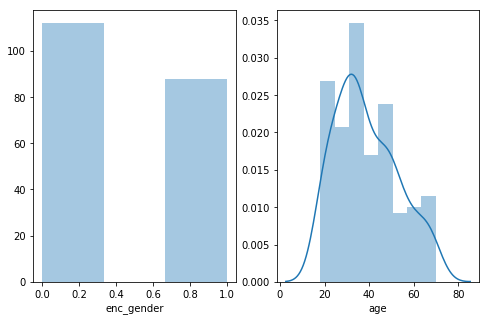

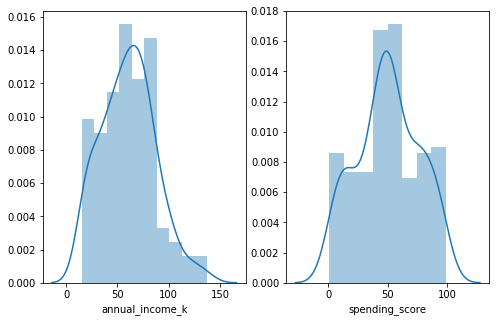

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

f = plt.figure(figsize=(8,5))
ax = f.add_subplot(121)
sns.distplot(ds["enc_gender"], kde=False)

ax = f.add_subplot(122)
sns.distplot(ds["age"])

f = plt.figure(figsize=(8,5))

ax = f.add_subplot(121)
sns.distplot(ds["annual_income_k"])

ax = f.add_subplot(122)
sns.distplot(ds["spending_score"])

* There are more female customers than male customers
* The most significat age segment is between 30 and 40 years,2nd is around 20 years and 3rd between 40 and 50
* Most significant segments in terms of annual income: 60K and 75 - 80K
* Spending score is the most important indicator in terms of sales - most significant: between 50 and 60, 2nd most significant 50 - 60; it is interesting to notice that 3rd is a score close to 100


Check the correlation between the features

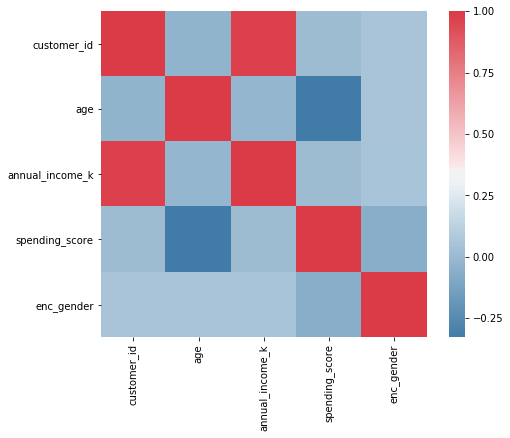

In [6]:
f, ax = plt.subplots(figsize=(8, 6))
corr = ds.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),square=True, ax=ax)

There is a high correlation between customer_id and annual_income.
There is also a small negative correlation between spending score and age (as one of them increases, the other decreases - so we might say that younger customers have the tendency to spend more). We will explore in detail the relation between each feature.

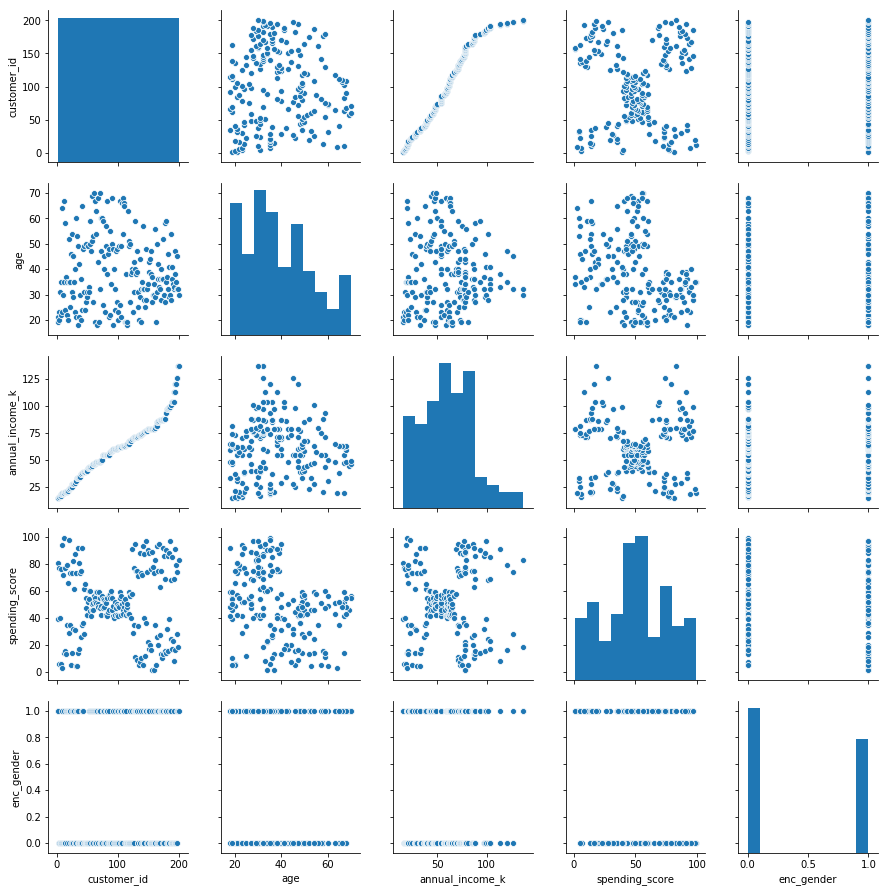

In [7]:
sns.pairplot(ds)

* customer_id increases with the annual_income_k
* spending score / annual_income_k, spending score / customer_id form groups of clients
* clients under 40 have a higher spending score
* clients with the highest annual income are between 30 and 50 years old

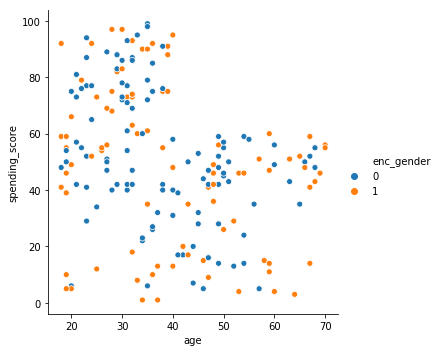

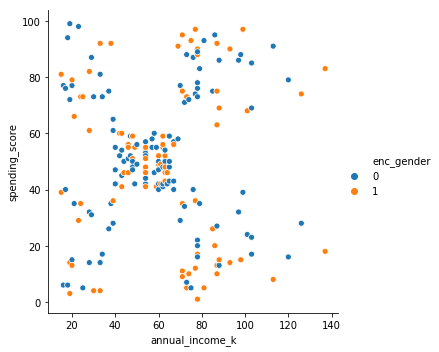

In [8]:
sns.relplot(x="age", y="spending_score", hue="enc_gender", data=ds)
sns.relplot(x="annual_income_k", y="spending_score", hue="enc_gender", data=ds)

First plot (age / spending_score)
* higher spending scores (60 - 100) correspond to clients between 18 and 40, with a higher number of females than males.
* spending scores between 40 - 60 is distributed more uniformely over all the ages
* a spending score between 0 and 40 is more common to clients aged between 35 and 55

Second plot (annual income / spending score)
* anual income 20 - 40K have a spending_score between 0 to 40  / 70 to 100
* annual income 40 - 70K are grouped at 40 to 60 pending score
* annual income 75K - 105K are grouped at a spending score between 0 to 40 / 70 to 100
* annual incomes over 115K look like outliers

 In order to avoid the correlation between customer_id and annual_income to influence the clusters, I will drop customer_id.

In [9]:
ds.drop(["customer_id"], axis=1, inplace=True)

Determining the optimal number of clusters using the elbow method
(from previous plots we obtained the indication of 5 clusters)

In [10]:
ds.head()

age  annual_income_k  spending_score  enc_gender
0   19               15              39           1
1   21               15              81           1
2   20               16               6           0
3   23               16              77           0
4   31               17              40           0

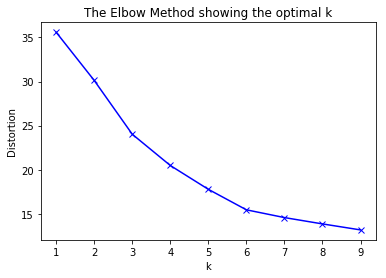

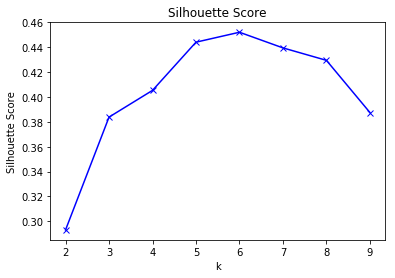

In [11]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


distortions = []
silhouette_sc = []
K = range(1,10)
for k in K:
    model = KMeans(n_clusters=k, random_state=15)
    model.fit(ds)
    distortions.append(sum(np.min(cdist(ds, model.cluster_centers_, 'euclidean'), axis=1)) / ds.shape[0])
    if k>=2:
        silhouette_sc.append(metrics.silhouette_score(ds, model.labels_))

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

plt.plot(range(2,10), silhouette_sc, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()



In [12]:
model = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=15)
y_pred = model.fit_predict(ds)
ds['cluster'] = y_pred
ds.head()

age  annual_income_k  spending_score  enc_gender  cluster
0   19               15              39           1        5
1   21               15              81           1        0
2   20               16               6           0        5
3   23               16              77           0        0
4   31               17              40           0        5

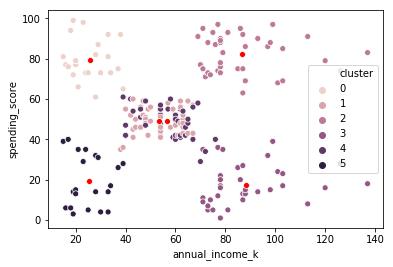

In [13]:
sns.scatterplot(x="annual_income_k", y="spending_score",hue="cluster", legend="full", data=ds)
sns.scatterplot(x=model.cluster_centers_[:,1], y=model.cluster_centers_[:,2], color='r')

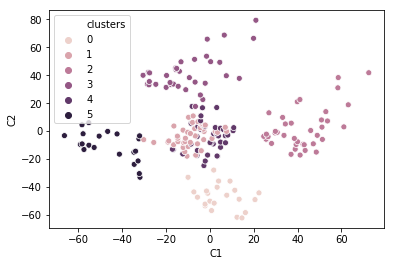

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
ds_features = ds.drop(["cluster"], axis=1)
ds_reduced = pca.fit_transform(ds_features)
ds2 = pd.DataFrame(ds_reduced, columns=["C1", "C2"])
ds2["clusters"] = pd.DataFrame(y_pred, columns=["clusters"])
sns.scatterplot(x="C1", y="C2",hue="clusters", legend="full", data=ds2)

In [15]:
model = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=15)
y_pred = model.fit_predict(ds)
ds['cluster'] = y_pred
ds.head()

age  annual_income_k  spending_score  enc_gender  cluster
0   19               15              39           1        2
1   21               15              81           1        0
2   20               16               6           0        2
3   23               16              77           0        0
4   31               17              40           0        2

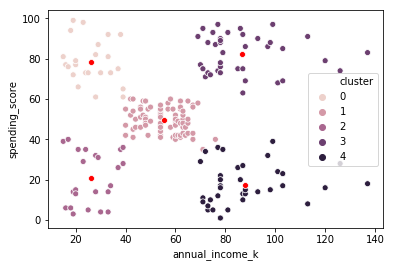

In [16]:
sns.scatterplot(x="annual_income_k", y="spending_score",hue="cluster", legend="full", data=ds)
sns.scatterplot(x=model.cluster_centers_[:,1], y=model.cluster_centers_[:,2], color='r')

In [17]:
model.cluster_centers_

array([[25.52173913, 26.30434783, 78.56521739,  0.39130435,  0.17391304],
       [43.08860759, 55.29113924, 49.56962025,  0.41772152,  2.35443038],
       [45.2173913 , 26.30434783, 20.91304348,  0.39130435,  4.65217391],
       [32.69230769, 86.53846154, 82.12820513,  0.46153846,  2.        ],
       [40.66666667, 87.75      , 17.58333333,  0.52777778,  3.05555556]])

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
ds_features = ds.drop(["cluster"], axis=1)
ds_reduced = pca.fit_transform(ds_features)

In [19]:
ds_reduced

array([[-3.18699448e+01, -3.30012521e+01],
       [ 7.64494048e-01, -5.68429006e+01],
       [-5.74082757e+01, -1.31249607e+01],
       [-2.16854252e+00, -5.34785900e+01],
       [-3.21740846e+01, -3.03884119e+01],
       [-2.17695183e+00, -5.22272685e+01],
       [-5.90656895e+01, -9.54376302e+00],
       [ 1.23708622e+01, -6.16180208e+01],
       [-6.63157690e+01, -3.21423160e+00],
       [-5.65556212e+00, -4.72672225e+01],
       [-5.82365979e+01, -9.13418751e+00],
       [ 1.46218043e+01, -6.21075685e+01],
       [-5.51608374e+01, -1.00799251e+01],
       [-3.02878331e-03, -5.01140754e+01],
       [-5.27646657e+01, -1.16807468e+01],
       [ 1.94661180e+00, -5.15222086e+01],
       [-3.45055496e+01, -2.37615402e+01],
       [-7.30493262e+00, -4.35151138e+01],
       [-4.12573070e+01, -1.64734737e+01],
       [ 1.61902860e+01, -5.83001207e+01],
       [-3.27400141e+01, -2.13347966e+01],
       [-9.81885245e-01, -4.44524038e+01],
       [-5.78100898e+01, -1.87057486e+00],
       [-1.

In [20]:

ds2 = pd.DataFrame(ds_reduced, columns=["C1", "C2"])
ds2["clusters"] = pd.DataFrame(y_pred, columns=["clusters"])
ds2

C1         C2  clusters
0   -31.869945 -33.001252         2
1     0.764494 -56.842901         0
2   -57.408276 -13.124961         2
3    -2.168543 -53.478590         0
4   -32.174085 -30.388412         2
..         ...        ...       ...
195  58.352515  31.017542         3
196  19.908001  66.446108         4
197  58.520804  38.346039         3
198  20.979130  79.376405         4
199  72.447693  41.811336         3

[200 rows x 3 columns]

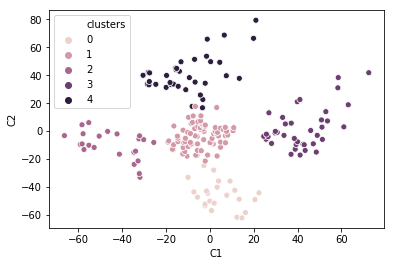

In [21]:
sns.scatterplot(x="C1", y="C2",hue="clusters", legend="full", data=ds2)